In [1]:
import sys
import re
import time
import datetime
import pandas as pd
import numpy as np
import func
# inline plot
import matplotlib.pyplot as plt
%matplotlib inline

/Users/albarron/anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
df = pd.read_csv("data/merged_concat_final.csv",sep='\t',error_bad_lines=False)
del df['Unnamed: 0']
print df.shape

(21021, 33)


In [5]:
df.set_index('timestamp')
df['timestamp'] = pd.to_datetime(df['timestamp'],format="%Y-%m-%d %H:%M:%S")

In [6]:
only_delay = df[(df['is_delay']==1)]

In [326]:
len(only_delay)

327

In [7]:
print "relative to delay"
print (df[['is_delay','del_min','del_med','del_maj','del_cat']].sum()/float(df['is_delay'].sum()))*100 , '%'
print "Relative to total"
print (df[['is_delay','del_min','del_med','del_maj','del_cat']].sum()/float(len(df)))*100 , '%'

relative to delay
is_delay    100.000000
del_min      27.828746
del_med      43.425076
del_maj       8.562691
del_cat       4.892966
dtype: float64 %
Relative to total
is_delay    1.555587
del_min     0.432900
del_med     0.675515
del_maj     0.133200
del_cat     0.076114
dtype: float64 %


In [8]:
# Train IDs swapped into cat variables and concat into main dataset
train_id_dummies = pd.get_dummies(df['train_id'],prefix='tid')
train_id_dummies.shape
train_id_dummies.columns.values
del train_id_dummies['tid_101.0'] # Delete as base var
tid_col = train_id_dummies.columns.values
df = pd.concat([df, train_id_dummies], axis=1)

### Pick one of these to explore re: below models

In [73]:
# Including train IDs
features = df.columns.values
target_cols = ['temp','precipiation',
        'visability','windspeed','humidity','cloudcover',
        'is_bullet','is_limited','t_northbound',
       'd_tuesday','d_wednesday','d_thursday','d_friday',] + list(tid_col)
X = df[target_cols]
# del X['is_delay']
# del X['tweet_id']
# X['timestamp'] = X['timestamp'].apply(lambda x: (np.datetime64(x).astype('uint64') / 1e6).astype('uint32'))
# y = df['ord_del']
y = df['is_delay']

In [ ]:
# Including train IDs
features = df.columns.values
target_cols = ['temp','precipiation',
        'visability','windspeed','humidity','cloudcover',
        'is_bullet','is_limited','t_northbound',
       'd_tuesday','d_wednesday','d_thursday','d_friday',] + list(tid_col)
X = df[target_cols]
# del X['is_delay']
# del X['tweet_id']
# X['timestamp'] = X['timestamp'].apply(lambda x: (np.datetime64(x).astype('uint64') / 1e6).astype('uint32'))
# y = df['ord_del']
y = df['is_delay']

In [74]:
# X['timestamp'] = X['timestamp'].apply(lambda x:int(x))
# X['stop_pa'] = X['stop_pa'].apply(lambda x:int(x))
# X['train_id'] = X['train_id'].apply(lambda x:int(x))
X['t_northbound'] = X['t_northbound'].apply(lambda x:int(x))
X['cloudcover'] = X['cloudcover'].fillna(X['cloudcover'].mean())

/Users/albarron/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/albarron/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


### Train/Test split

In [289]:
from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.25)

### Run Decision Trees, Prune, and consider False Positives

In [76]:
from sklearn.tree import DecisionTreeClassifier
TreeClass = DecisionTreeClassifier(
                max_depth = 2,
                min_samples_leaf = 5)
TreeClass.fit(X_train,y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=2,
            max_features=None, max_leaf_nodes=None, min_samples_leaf=5,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            random_state=None, splitter='best')

In [394]:
from sklearn import metrics
from sklearn.cross_validation import cross_val_score
scores = cross_val_score(TreeClass, X, y, cv=10)
print(scores.mean()) # Score = More is better, error is 1-score

0.992055614405


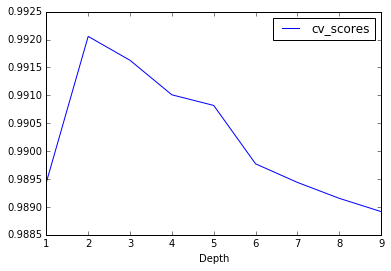

In [395]:
Depth = range(1,10)
score = []
for i in Depth:
      TreeClass = DecisionTreeClassifier(
                max_depth = i,
                min_samples_leaf = 5)
      scores = cross_val_score(TreeClass, X, y, cv=10)
      score.append(np.mean(scores))

Depth_Choice_df = pd.DataFrame({'cv_scores': score ,'Depth': Depth})
Depth_Choice_df.plot(x ='Depth',y = 'cv_scores' )

#It seems like at depth = 4 we achieved the best result

In [80]:
Depth_Choice_df.head()

,Depth,cv_scores
0,1,0.989345
1,2,0.992959
2,3,0.992389
3,4,0.992389
4,5,0.992769


In [ ]:
TreeClass = DecisionTreeClassifier(
                max_depth = 2,
                min_samples_leaf = 5)

In [405]:
TreeClass.fit(X_train,y_train)
ImportanceDataFrame = pd.DataFrame({'feature':X.columns.values, 'Gini_Import':TreeClass.feature_importances_})
ImportanceDataFrame.sort_values(by = ['Gini_Import'],ascending = 0).head(10)

,Gini_Import,feature
7,0.521470,is_limited
6,0.293549,is_bullet
0,0.051288,temp
5,0.033127,cloudcover
4,0.032764,humidity
3,0.016853,windspeed
10,0.010351,d_wednesday
2,0.008541,visability
17,0.006534,tid_135.0
12,0.005773,d_friday


In [94]:
df[['temp','precipiation','visability','windspeed','humidity','cloudcover']].corr()

,temp,precipiation,visability,windspeed,humidity,cloudcover
temp,1.000000,-0.209248,0.119720,0.333041,-0.345526,-0.158742
precipiation,-0.209248,1.000000,-0.459115,0.200260,0.303568,0.365534
visability,0.119720,-0.459115,1.000000,-0.119827,-0.427823,-0.343510
windspeed,0.333041,0.200260,-0.119827,1.000000,-0.004015,0.252678
humidity,-0.345526,0.303568,-0.427823,-0.004015,1.000000,0.487529
cloudcover,-0.158742,0.365534,-0.343510,0.252678,0.487529,1.000000


In [83]:
# http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html#example-model-selection-plot-confusion-matrix-py
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(2)
    plt.xticks(tick_marks, ['No Delay','Delay'], rotation=45)
    plt.yticks(tick_marks, ['No Delay','Delay'])
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix:
[[5164   12]
 [  41   39]]
Normalized
[[ 0.9977  0.0023]
 [ 0.5125  0.4875]]
Accuracy
0.9899 %
Misclass
0.0101 %
Sensitivity
0.4875 %
Specificity
0.9977 %


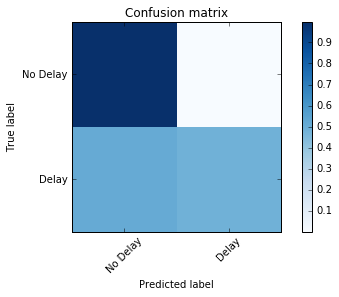

In [400]:
from sklearn.metrics import confusion_matrix
TreeClass.fit(X_train,y_train)
y_hat = TreeClass.predict(X_test)
cmat = confusion_matrix(y_test, y_hat)
c_norm = cmat.astype('float') / cmat.sum(axis=1)[:, np.newaxis]
print "Confusion matrix:"
print cmat
print "Normalized"
print np.round(c_norm,4)
plot_confusion_matrix(c_norm) # Normalized
print "Accuracy"
print np.round((cmat[1][1] + cmat[0][0]) / float(len(X_test)),4),'%'
print "Misclass"
print np.round((cmat[1][0] + cmat[0][1]) / float(len(X_test)),4),'%'
print "Sensitivity"
print np.round((cmat[1][1]) / float(cmat[1][1]+cmat[1][0]),4),'%'
print "Specificity"
print np.round((cmat[0][0]) / float(cmat[0][0]+cmat[0][1]),4),'%'

[ 0.00188127  0.00188127  0.00188127 ...,  0.00188127  0.00188127
  0.00188127]
0.837881568779


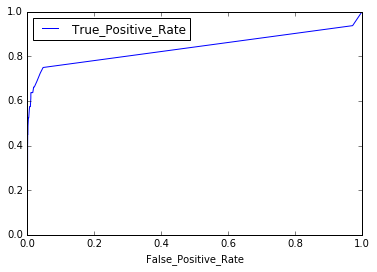

In [401]:
y_hat_probability = TreeClass.predict_proba(X_test).T[1] 
print(y_hat_probability)
print(roc_auc_score(y_test, y_hat_probability))
vals = roc_curve(y_test, y_hat_probability)  
Roc_DataFrame = pd.DataFrame({'False_Positive_Rate':vals[0],'True_Positive_Rate':vals[1]})
Roc_DataFrame.plot(x = 'False_Positive_Rate' , y = 'True_Positive_Rate' ) 

[ 0.00577886  0.00577886  0.00577886 ...,  0.00577886  0.00577886
  0.00577886]
0.805011108964


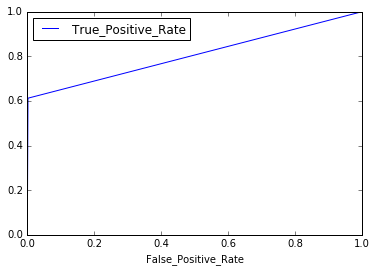

In [390]:
from sklearn.metrics import roc_curve, auc,roc_auc_score
TreeClass.fit(X_train,y_train)
y_hat_probability = TreeClass.predict_proba(X_test).T[1] 
print(y_hat_probability)
print(roc_auc_score(y_test, y_hat_probability))
vals = roc_curve(y_test, y_hat_probability)  
Roc_DataFrame = pd.DataFrame({'False_Positive_Rate':vals[0],'True_Positive_Rate':vals[1]})
Roc_DataFrame.plot(x = 'False_Positive_Rate' , y = 'True_Positive_Rate' ) 

### As a check, consider Feature selection

In [404]:
from sklearn import feature_selection
pvals = feature_selection.f_regression(X,y)[1] 
pd.DataFrame(sorted(zip(X.columns.values,np.round(pvals,4)),key=lambda x:x[1],reverse=True),columns=['Feature','Value']).head(5)

,Feature,Value
0,tid_139.0,0.8279
1,tid_221.0,0.8279
2,tid_231.0,0.8279
3,tid_257.0,0.8279
4,tid_274.0,0.8279


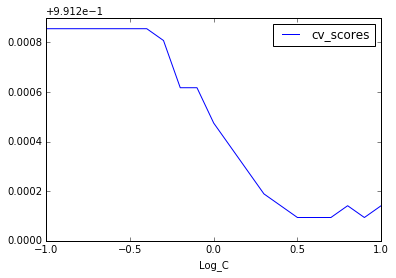

In [60]:
from sklearn.linear_model import LogisticRegression
lm = LogisticRegression()
lm.fit(X,y)
X_lr=df[['windspeed','t_northbound','precipiation','d_friday']]
# localize your search around the maximum value you found
c_list = np.logspace(-1,1,21) 
c_index = np.linspace(-1,1,21)
#C is just the inverse of Lambda - the smaller the C - the stronger the
#regulatization. The smaller C's choose less variables
cv_scores = []
for c_score in c_list:
    lm = LogisticRegression(C = c_score, penalty = "l1")
    cv_scores.append(cross_val_score(lm,X,y,cv=10).mean())


C_Choice_df = pd.DataFrame({'cv_scores': cv_scores ,'Log_C': c_index })
C_Choice_df.plot(x ='Log_C',y = 'cv_scores' )
# it sounds like our best choice is C = -0.1  (we chose the most restrictive option)

In [100]:
X.head()

,temp,precipiation,visability,windspeed,humidity,cloudcover,is_bullet,is_limited,t_northbound,d_tuesday,...,tid_365.0,tid_366.0,tid_370.0,tid_371.0,tid_375.0,tid_376.0,tid_380.0,tid_381.0,tid_385.0,tid_386.0
0,72.97875,0,10,6.68125,0.62875,0.09875,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,72.97875,0,10,6.68125,0.62875,0.09875,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,72.97875,0,10,6.68125,0.62875,0.09875,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,72.97875,0,10,6.68125,0.62875,0.09875,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,72.97875,0,10,6.68125,0.62875,0.09875,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Run for Boosting

In [195]:
from sklearn.ensemble import GradientBoostingClassifier
GBC_Tree = GradientBoostingClassifier(learning_rate = 0.01,
                                      n_estimators = 10000,
                                      max_depth = 2,
                                      min_samples_leaf = 5)
 

from sklearn import cross_validation
kf = cross_validation.KFold(len(df), n_folds = 10, shuffle = True) #10 fold CV
scores = []
for train_index, test_index in kf:        
        GBC_Tree.fit(X.iloc[train_index], y.iloc[train_index])
        y_hat_test = GBC_Tree.predict(X.iloc[test_index]) 
        scores.append(float(sum(y_hat_test == y.iloc[test_index]))/len(y_hat_test))

Score_GBC_CV = np.mean(scores)    

print(Score_GBC_CV)

0.991484888834


Training the Boosting classifier

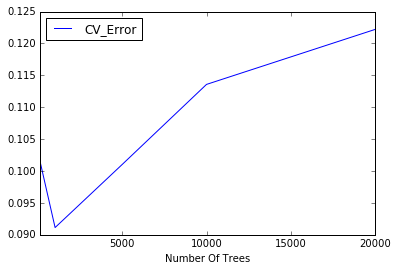

In [361]:
Score = []
NumberOfTrees = [100,1000,5000,10000,20000]
for i in NumberOfTrees:
    GBR_Tree = GradientBoostingClassifier(learning_rate = 0.01,
                                 n_estimators = i,
                                 max_depth = 2,
                                 min_samples_leaf = 5  )  
    scores = cross_val_score(GBR_Tree, X, y, cv=10, scoring='mean_squared_error')
    Score.append(np.mean(np.sqrt(-scores)))

Depth_Choice_df = pd.DataFrame({'CV_Error': Score ,'Number Of Trees': NumberOfTrees})
Depth_Choice_df.plot(x ='Number Of Trees',y = 'CV_Error' )

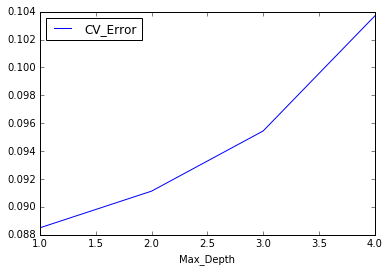

In [360]:
Depth = range(1,5)
Score = []
for i in Depth:
    GBR_Tree = GradientBoostingClassifier(learning_rate = 0.01,
                                 n_estimators = 1000,
                                 max_depth = i,
                                 min_samples_leaf = 5  )  
    scores = cross_val_score(GBR_Tree, X, y, cv=10, scoring='mean_squared_error')
    Score.append(np.mean(np.sqrt(-scores)))

Depth_Choice_df = pd.DataFrame({'CV_Error': Score ,'Max_Depth': Depth})
Depth_Choice_df.plot(x ='Max_Depth',y = 'CV_Error' )

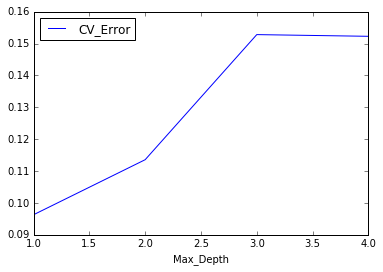

In [362]:
Depth = range(1,5)
Score = []
for i in Depth:
    GBR_Tree = GradientBoostingClassifier(learning_rate = 0.01,
                                 n_estimators = 10000,
                                 max_depth = i,
                                 min_samples_leaf = 5  )  
    scores = cross_val_score(GBR_Tree, X, y, cv=10, scoring='mean_squared_error')
    Score.append(np.mean(np.sqrt(-scores)))

Depth_Choice_df = pd.DataFrame({'CV_Error': Score ,'Max_Depth': Depth})
Depth_Choice_df.plot(x ='Max_Depth',y = 'CV_Error' )

### Tuned Tree and running model

In [363]:
# TUNED TREE
GBR_Tree = GradientBoostingClassifier(learning_rate = 0.01,
                                     n_estimators = 1000,
                                     max_depth = 1,
                                     min_samples_leaf = 5  ) 

In [365]:
GBC_Tree.fit(X_train,y_train)
ImportanceDataFrame = pd.DataFrame({'feature':X.columns.values, 'Importance':GBC_Tree.feature_importances_})
ImportanceDataFrame.sort_values(by = ['Importance'],ascending = 0).head(10)

,Importance,feature
0,0.169679,temp
4,0.167738,humidity
5,0.152647,cloudcover
3,0.149600,windspeed
2,0.083236,visability
12,0.037309,d_friday
7,0.028038,is_limited
9,0.025530,d_tuesday
1,0.021733,precipiation
11,0.019582,d_thursday


Confusion matrix:
[[5166   10]
 [  38   42]]
Normalized
[[ 0.9981  0.0019]
 [ 0.475   0.525 ]]
Accuracy
0.9909 %
Misclass
0.0091 %
Sensitivity
0.525 %
Specificity
0.9981 %


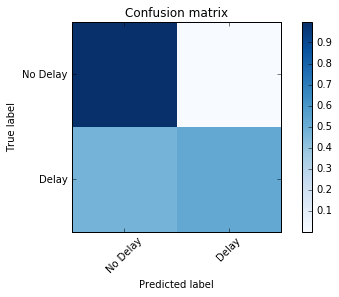

In [397]:
from sklearn.metrics import confusion_matrix
y_hat = GBC_Tree.predict(X_test)
cmat = confusion_matrix(y_test, y_hat)
c_norm = cmat.astype('float') / cmat.sum(axis=1)[:, np.newaxis]
print "Confusion matrix:"
print cmat
print "Normalized"
print np.round(c_norm,4)
plot_confusion_matrix(c_norm) # Normalized
print "Accuracy"
print np.round((cmat[1][1] + cmat[0][0]) / float(len(X_test)),4),'%'
print "Misclass"
print np.round((cmat[1][0] + cmat[0][1]) / float(len(X_test)),4),'%'
print "Sensitivity"
print np.round((cmat[1][1]) / float(cmat[1][1]+cmat[1][0]),4),'%'
print "Specificity"
print np.round((cmat[0][0]) / float(cmat[0][0]+cmat[0][1]),4),'%'

Accuracy
0.248 %
Misclass
0.002 %
Sensitivity
0.6125 %
Specificity
0.9977 %


### Prediction Prototype

In [202]:
import forecastio
keys = pd.read_csv('keys.csv') # hidden from github
forecaseiokey=keys.iloc[5].string
api_key = forecaseiokey
lat = 37.441879
lng = -122.143021

In [204]:
print current.d

{u'ozone': 364.43, u'temperature': 64.79, u'icon': u'clear-day', u'dewPoint': 49.88, u'humidity': 0.58, u'visibility': 9.92, u'summary': u'Clear', u'apparentTemperature': 64.79, u'pressure': 1015.48, u'windSpeed': 6.9, u'cloudCover': 0.12, u'time': 1459377043, u'windBearing': 321, u'precipIntensity': 0, u'precipProbability': 0}


In [324]:
def get_train_prediction(trainid,threshold=0.2):
    The_train = str(trainid)

    time = datetime.datetime.now()
    forecast = forecastio.load_forecast(api_key, lat, lng,time=time)
    current = forecast.currently()

    Predict_me = pd.DataFrame({
            'temp': [current.d['apparentTemperature']],
            'precipiation': [current.d['precipIntensity']],
            'visability': [current.d['visibility']],
            'windspeed': [current.d['windSpeed']],
            'humidity': [current.d['humidity']],
            'cloudcover': [current.d['cloudCover']],
            'is_bullet': 1 if str(The_train)[0] == '2' else 0,
            'is_limited':1 if str(The_train)[0] == '3' else 0,
            't_northbound': int(The_train)%2,
            'd_tuesday': 1 if time.weekday == 1 else 0,
            'd_wednesday':1 if time.weekday == 2 else 0,
            'd_thursday':1 if time.weekday == 3 else 0,
            'd_friday':1 if time.weekday == 4 else 0
            })


    t = pd.DataFrame(columns=tid_col)
    t = t.append([0]).fillna(0)
    t['tid_'+The_train+'.0'] = 1
    t['tid_'+The_train+'.0']
    Predict_me = pd.concat([Predict_me, t],axis=1)
    del Predict_me[0]
    pprob = GBC_Tree.predict_proba(Predict_me).T
    pred = 1 if pprob[1] >= threshold else 0 # GBC_Tree.predict(Predict_me)
    print "Will be delayed:",pred
    print "Probability:",np.round(pprob.T,4)
    return [pred,pprob]

In [383]:
get_train_prediction(381)

Will be delayed: 0
Probability: [[ 0.  1.]]



[0, array([[  3.91950517e-05],
        [  9.99960805e-01]])]

### Hamed Feedback
- Set threshold to 70% for predibility
- Tolerance is only 5% delay mispredict
- Look at lecture 9

Confusion matrix:
[[5130   46]
 [  29   51]]
Normalized
[[ 0.9911  0.0089]
 [ 0.3625  0.6375]]
Accuracy
0.9857 %
Misclass
0.0143 %
Sensitivity
0.6375 %
Specificity
0.9911 %


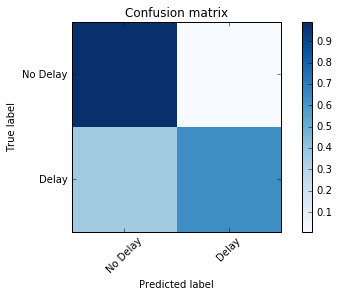

In [412]:
def PredictThreshold(Predictprob,Threshhold):
    y_predict = 0
    if (Predictprob >= Threshhold):
        y_predict = 1
    return y_predict


y_hat_probability = GBC_Tree.predict_proba(X_test).T[1]
y_hat_predict_threshold = []
threshold = 0.1# Changing down increases false positive, changing up increases false negative
for i in range(0,len(y_hat_probability)):
    y_hat_predict_threshold.append(PredictThreshold(y_hat_probability[i],threshold))

cmat = confusion_matrix(y_test, y_hat_predict_threshold)
c_norm = cmat.astype('float') / cmat.sum(axis=1)[:, np.newaxis]
print "Confusion matrix:"
print cmat
print "Normalized"
print np.round(c_norm,4)
plot_confusion_matrix(c_norm) # Normalized
print "Accuracy"
print np.round((cmat[1][1] + cmat[0][0]) / float(len(X_test)),4),'%'
print "Misclass"
print np.round((cmat[1][0] + cmat[0][1]) / float(len(X_test)),4),'%'
print "Sensitivity"
print np.round((cmat[1][1]) / float(cmat[1][1]+cmat[1][0]),4),'%'
print "Specificity"
print np.round((cmat[0][0]) / float(cmat[0][0]+cmat[0][1]),4),'%'

In [370]:
# GBC_Tree = GradientBoostingClassifier(learning_rate = 0.01,
#                                       n_estimators = 10000,
#                                       max_depth = 3,
#                                       min_samples_leaf = 5)
# GBC_Tree.fit(X_train,y_train)
cmatrix = []
y_hat_probability = GBC_Tree.predict_proba(X_test).T[1]
for t in range(0,100,1):
    y_hat_predict_threshold = []
    cm = []
    thresh = t/100.0
    for i in range(0,len(y_hat_probability)):
        y_hat_predict_threshold.append(PredictThreshold(y_hat_probability[i],thresh))
    cm = confusion_matrix(y_test, y_hat_predict_threshold)
    cmatrix.append([thresh,cm[0][0],cm[0][1],cm[1][0],cm[1][1]])
thmatrix = pd.DataFrame(cmatrix, columns=['Thresh','T_ND','F_ND','F_D','T_D'])

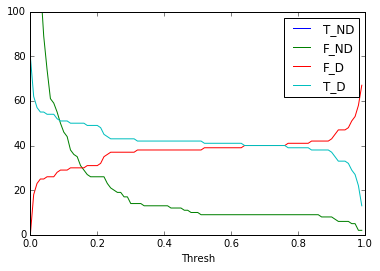

In [371]:
thmatrix.set_index('Thresh')
thmatrix.plot(x='Thresh',y=['T_ND','F_ND','F_D','T_D'],kind='line', ylim=(0,100),xlim=(0.,1.))

In [372]:
thmatrix['acc'] = thmatrix.apply(lambda x:(x.T_D + x.T_ND) / float(len(thmatrix)),axis=1)
thmatrix['miss'] = thmatrix.apply(lambda x:(x.F_D + x.F_ND) / float(len(thmatrix)),axis=1)
thmatrix['sens'] = thmatrix.apply(lambda x:(x.T_D) / float(x.T_D+x.F_D),axis=1)
thmatrix['spec'] = thmatrix.apply(lambda x:(x.T_ND / float(x.T_ND+x.F_ND)),axis=1)

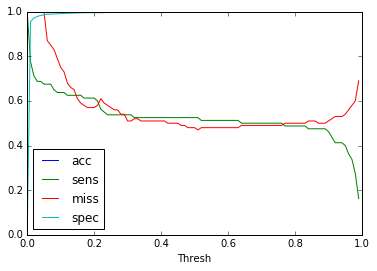

In [373]:
thmatrix.plot(x='Thresh',y=['acc','sens','miss','spec'],kind='line', ylim=(0.,1.0),xlim=(0.,1.))

[  1.00857726e-05   2.10989167e-05   4.64425388e-04 ...,   3.22592500e-04
   4.09920987e-04   1.23469160e-04]
0.928948512365


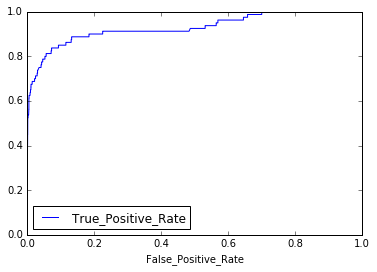

In [391]:
y_hat_probability = GBC_Tree.predict_proba(X_test).T[1] 
print(y_hat_probability)
print(roc_auc_score(y_test, y_hat_probability))
vals = roc_curve(y_test, y_hat_probability)  
Roc_DataFrame = pd.DataFrame({'False_Positive_Rate':vals[0],'True_Positive_Rate':vals[1]})
Roc_DataFrame.plot(x = 'False_Positive_Rate' , y = 'True_Positive_Rate' ) 

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
GBC_Tree = GradientBoostingClassifier(learning_rate = 0.01,
                                      n_estimators = 10000,
                                      max_depth = 2,
                                      min_samples_leaf = 5)
 

from sklearn import cross_validation
kf = cross_validation.KFold(len(df), n_folds = 10, shuffle = True) #10 fold CV
scores = []
for train_index, test_index in kf:        
        GBC_Tree.fit(X.iloc[train_index], y.iloc[train_index])
        y_hat_test = GBC_Tree.predict_probadi(X.iloc[test_index])
        y_hat_predict_threshold.append(PredictThreshold(y_hat_probability[i],0.05))
        scores.append(float(sum(y_hat_test == y.iloc[test_index]))/len(y_hat_test))

Score_GBC_CV = np.mean(scores)    

print(Score_GBC_CV)

In [428]:
drames = pd.read_csv("data/all_stops_in_pa.csv",sep=',',error_bad_lines=False)

In [429]:
dat = []
for i in drames.values:
    if i[0] == 101: pass
    else:
        pred = get_train_prediction(i[0])
        s=pd.Series({'id':i[0],'time':i[1],'dir':i[2],'pred':pred})
        dat.append(s)
d = pd.DataFrame(dat)

[102 '05:53' 1]
Will be delayed: 1
Probability: [[ 0.9902  0.0098]]

[104 '06:23' 1]
Will be delayed: 0
Probability: [[ 0.4003  0.5997]]

[206 '06:59' 1]
Will be delayed: 0
Probability: [[  7.00000000e-04   9.99300000e-01]]

[208 '07:20' 1]
Will be delayed: 0
Probability: [[  7.00000000e-04   9.99300000e-01]]

[210 '07:28' 1]
Will be delayed: 0
Probability: [[  7.00000000e-04   9.99300000e-01]]

[312 '07:38' 1]
Will be delayed: 0
Probability: [[  3.00000000e-04   9.99700000e-01]]

[314 '07:53' 1]
Will be delayed: 0
Probability: [[  3.00000000e-04   9.99700000e-01]]

[216 '08:05' 1]
Will be delayed: 0
Probability: [[  7.00000000e-04   9.99300000e-01]]

[218 '08:20' 1]
Will be delayed: 0
Probability: [[  7.00000000e-04   9.99300000e-01]]

[220 '08:28' 1]
Will be delayed: 0
Probability: [[  7.00000000e-04   9.99300000e-01]]

[322 '08:38' 1]
Will be delayed: 0
Probability: [[  3.00000000e-04   9.99700000e-01]]

[324 '08:53' 1]
Will be delayed: 0
Probability: [[  3.00000000e-04   9.99700000

dir                                              1
id                                             196
pred    [0, [[0.971472829122], [0.0285271708779]]]
time                                         23:38
dtype: object

In [431]:
prob = pd.DataFrame(dat)

In [438]:
prob['pred'][0]

list

In [450]:
def ref(t):
    l = list(t)
    return pd.Series([l[0],l[1][0][0],l[1][1][0]])

In [454]:
prob[['is_delay','prob_delay','prob_nodelay']] = prob['pred'].apply(lambda x:ref(x))

In [456]:
del prob['pred']

/Users/albarron/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:4: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


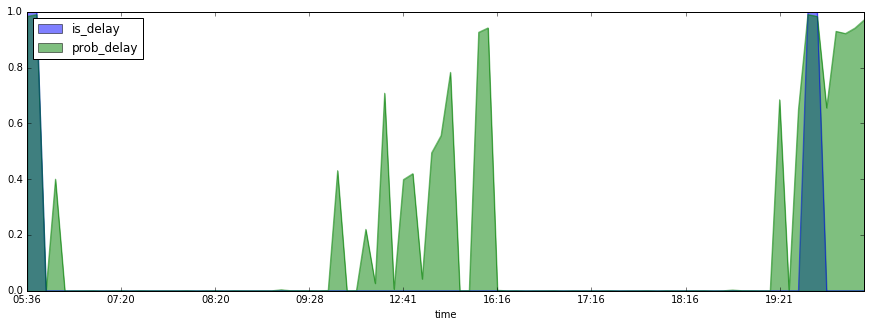

In [474]:
prob.set_index('time')

prob.sort_index(inplace=True)
prob.sort('time').plot.area(x='time',y=['is_delay','prob_delay',],figsize=(15,5),stacked=False)

In [466]:
prob.sort('time')

/Users/albarron/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  if __name__ == '__main__':


,dir,id,time,is_delay,prob_delay,prob_nodelay
45,1,103,05:36,1,0.983692,0.016308
0,1,102,05:53,1,0.990210,0.009790
46,1,305,06:05,0,0.000039,0.999961
1,1,104,06:23,0,0.400328,0.599672
48,1,309,06:23,0,0.000039,0.999961
47,1,207,06:36,0,0.000396,0.999604
49,0,211,06:40,0,0.000396,0.999604
2,1,206,06:59,0,0.000680,0.999320
50,1,313,07:05,0,0.000039,0.999961
51,1,215,07:16,0,0.000396,0.999604
